# Group 14 - Project FP01
## Time series anomaly detection

This project aims at investigating the current state-of-the-arts TAD scenario.

In [1]:
import os
import time
import tsfel
import warnings
import datetime
import keras_tuner as kt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.cm as cm
from sklearn import metrics
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn import preprocessing
import plotly.graph_objects as go
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import VarianceThreshold


import dataset as ds

In [2]:
# Path to the root directory of the dataset
ROOTDIR_DATASET_NORMAL = './dataset/normal/'
ROOTDIR_DATASET_COLLISION = './dataset/collisions/'

In [3]:
# TF_ENABLE_ONEDNN_OPTS=0 means that the model will not use the oneDNN library for optimization

import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

### Dataset: Kuka-v1
In 5 different recording sessions, the robot executes several different operations, while being
monitored by several sensors. The sensed signals are collected, with different sampling frequencies
(1, 10, 100, 200 Hz),

In [4]:
# Dataset frequency
freq_01s = '0.1'
freq_001s = '0.01'
freq_0005s = '0.005'

### Data Loading

In [5]:
def get_df_action(filepaths_csv, filepaths_meta, action2int=None, delimiter=";"):
    # Load dataframes
    print("Loading data.")
    # Make dataframes
    # Some classes show the output boolean parameter as True rather than true. Fix here
    dfs_meta = list()
    for filepath in filepaths_meta:
        df_m = pd.read_csv(filepath, sep=delimiter)
        df_m.str_repr = df_m.str_repr.str.replace('True', 'true')
        df_m['filepath'] = filepath
        dfs_meta.append(df_m)

    df_meta = pd.concat(dfs_meta)
    df_meta.index = pd.to_datetime(df_meta.init_timestamp.astype('datetime64[ms]'), format="%Y-%m-%dT%H:%M:%S.%f")
    df_meta['completed_timestamp'] = pd.to_datetime(df_meta.completed_timestamp.astype('datetime64[ms]'),
                                                    format="%Y-%m-%dT%H:%M:%S.%f")
    df_meta['init_timestamp'] = pd.to_datetime(df_meta.init_timestamp.astype('datetime64[ms]'),
                                               format="%Y-%m-%dT%H:%M:%S.%f")

    # Eventually reduce number of classes
    # df_meta['str_repr'] = df_meta.str_repr.str.split('=', expand = True,n=1)[0]
    # df_meta['str_repr'] = df_meta.str_repr.str.split('(', expand=True, n=1)[0]

    actions = df_meta.str_repr.unique()
    dfs = [pd.read_csv(filepath_csv, sep=";") for filepath_csv in filepaths_csv]
    df = pd.concat(dfs)

    # Sort columns by name !!!
    df = df.sort_index(axis=1)

    # Set timestamp as index
    df.index = pd.to_datetime(df.time.astype('datetime64[ms]'), format="%Y-%m-%dT%H:%M:%S.%f")
    # Drop useless columns
    columns_to_drop = [column for column in df.columns if "Abb" in column or "Temperature" in column]
    df.drop(["machine_nameKuka Robot_export_active_energy",
             "machine_nameKuka Robot_import_reactive_energy"] + columns_to_drop, axis=1, inplace=True)
    signals = df.columns

    df_action = list()
    for action in actions:
        for index, row in df_meta[df_meta.str_repr == action].iterrows():
            start = row['init_timestamp']
            end = row['completed_timestamp']
            df_tmp = df.loc[start: end].copy()
            df_tmp['action'] = action
            # Duration as string (so is not considered a feature)
            df_tmp['duration'] = str((row['completed_timestamp'] - row['init_timestamp']).total_seconds())
            df_action.append(df_tmp)
    df_action = pd.concat(df_action, ignore_index=True)
    df_action.index = pd.to_datetime(df_action.time.astype('datetime64[ms]'), format="%Y-%m-%dT%H:%M:%S.%f")
    df_action = df_action[~df_action.index.duplicated(keep='first')]

    # Drop NaN
    df = df.dropna(axis=0)
    df_action = df_action.dropna(axis=0)

    if action2int is None:
        action2int = dict()
        j = 1
        for label in df_action.action.unique():
            action2int[label] = j
            j += 1

    df_merged = df.merge(df_action[['action']], left_index=True, right_index=True, how="left")
    # print(f"df_merged len: {len(df_merged)}")
    # Where df_merged in NaN Kuka is in idle state
    df_idle = df_merged[df_merged['action'].isna()].copy()
    df_idle['action'] = 'idle'
    df_idle['duration'] = df_action.duration.values.astype(float).mean().astype(str)
    df_action = pd.concat([df_action, df_idle])

    # ile label must be 0 for debug mode
    action2int['idle'] = 0
    print(f"Found {len(set(df_action['action']))} different actions.")
    print("Loading data done.\n")

    return df_action, df, df_meta, action2int

In [6]:
filepath_csv = [os.path.join(ROOTDIR_DATASET_NORMAL, f"rec{r}_20220811_rbtc_0.1s.csv") for r in [0, 2, 3, 4]]
filepath_meta = [os.path.join(ROOTDIR_DATASET_NORMAL, f"rec{r}_20220811_rbtc_0.1s.metadata") for r in [0, 2, 3, 4]]
df_action, df, df_meta, action2int = get_df_action(filepath_csv, filepath_meta)

Loading data.
Found 31 different actions.
Loading data done.



In [7]:
fig = go.Figure()
signals = [
    "sensor_id1_AngY",
    "sensor_id2_AngX",
    "sensor_id5_AngY",
    "sensor_id4_AccZ",
    "sensor_id4_AngX",
    "machine_nameKuka Robot_power"]

start = df.index[9000]
df_reduced = df.loc[start:]
duration = 120  # seconds
time_delta = df_reduced.index - start
df_interval = df_reduced[time_delta.total_seconds() <= duration]
j = 0

# Leveraging plotly express
n_colors = len(signals)
colors = px.colors.sample_colorscale("greys", [n/(n_colors -1) for n in range(n_colors)])  # From continuous colormap
colors = px.colors.qualitative.Set2  # From discrete colormap, see https://plotly.com/python/discrete-color/
df_signals = df_interval[signals].select_dtypes(['number'])
df_signals = df_signals / df_signals.max()
fig = px.line(df_signals, x=df_signals.index, y=df_signals.columns, color_discrete_sequence=colors)

# Leveraging plotly graph object
colors_action = px.colors.qualitative.Antique
j = 0
for action in df_action.loc[df_interval.index].action.unique():
    df_action_interval = df_action.loc[df_interval.index]
    df_action_single_action = df_action_interval[df_action_interval['action'] == action]
    fig.add_trace(go.Scatter(
        x=df_action_single_action.index,
        y=[-0.3] * len(df_action_single_action.index),
        line_shape="hv",
        line=dict(color=colors_action[j], width=2.5),
        name=action))
    j += 1

In [8]:

fig.update_layout(
    title="Some signals",
    xaxis_title="Time",
    yaxis_title="",
    legend_title="Legend",
    font=dict(
        family="Courier New, monospace",
        size=12,
        color="Black"
    )
)
fig.show()

In [9]:
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

def get_features_ts(domain, df_action, df_meta, frequency, action2int):
    duration_dict = {1: 10, 10: 1, 100: 0.1, 200: 0.05}
    duration_min = duration_dict[int(frequency)]
    cfg = tsfel.get_features_by_domain(domain)
    dataframe_features = list()
    print("Computing features.")
    # Idle does not have associated timestamps. Window is set to 10 seconds
    df_by_action = df_action[df_action["action"] == "idle"].copy()
    X = tsfel.time_series_features_extractor(cfg,
                                             df_by_action.select_dtypes(['number']),
                                             fs=frequency,
                                             header_names=df_by_action.select_dtypes(['number']).columns + '-',
                                             window_size=int(frequency * 10),
                                             verbose=False)
    time = pd.to_datetime(df_by_action.time.astype('datetime64[ms]'), format="%Y-%m-%dT%H:%M:%S.%f")
    X['start'] = [t[0] for t in
                  tsfel.utils.signal_processing.signal_window_splitter(time, window_size=int(frequency * 10))]
    X['duration'] = 10
    X['end'] = X['start'] + pd.to_timedelta(X['duration'], 's')
    X['label'] = action2int["idle"]
    X.drop('duration', inplace=True, axis=1)
    dataframe_features.append(X)
    actions = list(df_action.action.unique())
    actions.remove("idle")
    for action in actions:
        df_by_action = df_action[df_action["action"] == action].copy()
        df_meta_by_action = df_meta[df_meta['str_repr'] == action].copy()
        df_meta_by_action['start'] = pd.to_datetime(df_meta_by_action.init_timestamp.astype('datetime64[ms]'),
                                                    format="%Y-%m-%dT%H:%M:%S.%f")
        df_meta_by_action['end'] = pd.to_datetime(
            df_meta_by_action.completed_timestamp.astype('datetime64[ms]'), format="%Y-%m-%dT%H:%M:%S.%f")
        for _, row in df_meta_by_action.iterrows():
            df_by_action_by_event = df_by_action.loc[row["start"]: row["end"]]
            if len(df_by_action_by_event) < duration_min * frequency:
                print(f"Skipped feature extraction for {action} {row['start']} : {row['end']}.")
                continue

            X = tsfel.calc_window_features(cfg,
                                           df_by_action_by_event.select_dtypes(['number']),
                                           header_names=df_by_action_by_event.select_dtypes(['number']).columns + '-',
                                           fs=frequency,
                                           verbose=False)
            # print(X.shape)
            X['label'] = action2int[action]
            X['start'] = row['start']
            X['end'] = row['end']
            dataframe_features.append(X)

    dataframe_features = pd.concat(dataframe_features)
    print("Computing features done.")
    return dataframe_features

In [10]:
start_time = time.time()
df_features = get_features_ts("statistical", df_action, df_meta, 10, action2int)
print("--- %s seconds ---" % (time.time() - start_time))

Computing features.


Skipped feature extraction for pickFromPallet(1,2)=[true,1,0] 2022-08-11 14:37:37.436000 : 2022-08-11 14:37:37.421000.
Skipped feature extraction for placeToPallet(1,1)=[true,0] 2022-08-11 14:37:37.421000 : 2022-08-11 14:37:37.442000.
Skipped feature extraction for pickFromPallet(3,2)=[true,1,0] 2022-08-11 15:36:32.568000 : 2022-08-11 15:36:32.533000.
Skipped feature extraction for pickFromPallet(3,2)=[true,1,0] 2022-08-11 15:36:32.572000 : 2022-08-11 15:36:32.561000.
Skipped feature extraction for placeToPallet(1,3)=[true,0] 2022-08-11 15:36:32.533000 : 2022-08-11 15:36:32.572000.
Skipped feature extraction for placeToPallet(1,3)=[true,0] 2022-08-11 15:36:32.561000 : 2022-08-11 15:36:32.561000.
Computing features done.
--- 85.65672516822815 seconds ---


In [11]:
df_features.isnull().values.any()

True

In [12]:
# df_features_nonan = df_features.drop((df_features.columns[df_features.isna().any()].tolist()), axis=1)
df_features_nonan = df_features.fillna(0)

In [13]:
df_train, df_test = train_test_split(df_features_nonan)

In [14]:
X_train = df_train.drop(["label", "start", "end"], axis=1)
y_train = df_train["label"]
X_test = df_test.drop(["label", "start", "end"], axis=1)
y_test = df_test["label"]

In [15]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (729, 2200)
y_train shape: (729,)
X_test shape: (244, 2200)
y_test shape: (244,)


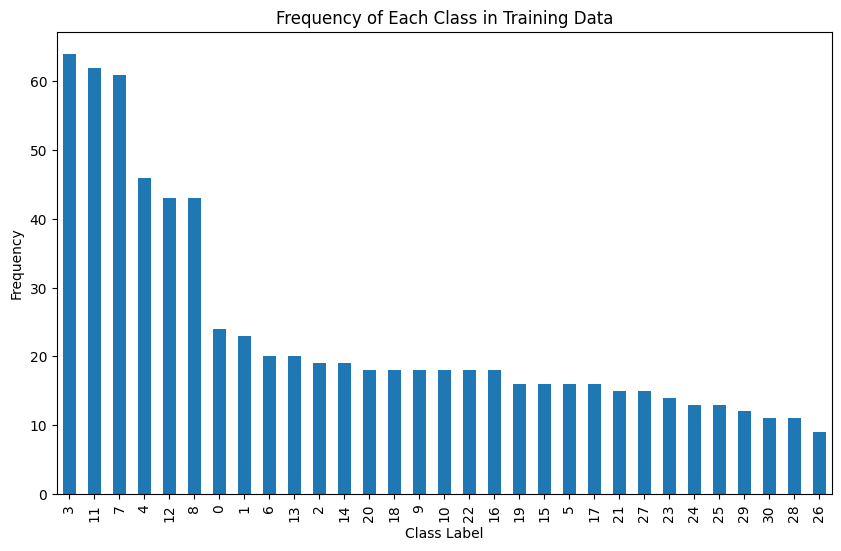

In [16]:
import matplotlib.pyplot as plt

# Count the occurrence of each class
label_counts = y_train.value_counts()

# Create a bar plot
plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar')
plt.title('Frequency of Each Class in Training Data')
plt.xlabel('Class Label')
plt.ylabel('Frequency')
plt.show()

In [17]:
y_train

0    10
4     0
0    12
0    12
0    16
     ..
0     1
0    30
0    15
0    17
0     4
Name: label, Length: 729, dtype: int64

In [18]:
# Normalise features
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)

# Remove zero-variance features
selector_variance = VarianceThreshold()
selector_variance.fit(X_train)
X_train = pd.DataFrame(selector_variance.transform(X_train),
                        columns=X_train.columns.values[selector_variance.get_support()])

# Remove highly correlated features
corr_features = tsfel.correlated_features(X_train,
                                          threshold=0.95)
X_train.drop(corr_features, inplace=True, axis=1)

# Lasso selector
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X_train, y_train)
lasso = SelectFromModel(lsvc, prefit=True)
selected_features = X_train.columns.values[lasso.get_support()]
X_train = X_train[selected_features].copy()

# Labels
num_classes = len(set(y_train))
y_train_categorical = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)

# Test
X_test = pd.DataFrame(selector_variance.transform(scaler.transform(X_test)),
                      columns=X_test.columns.values[selector_variance.get_support()])
X_test.drop(corr_features, inplace=True, axis=1)
X_test = X_test[selected_features].copy()

In [19]:
y_train_categorical

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [20]:
y_train

0    10
4     0
0    12
0    12
0    16
     ..
0     1
0    30
0    15
0    17
0     4
Name: label, Length: 729, dtype: int64

In [21]:
y_train_categorical[0, 20]

0.0

In [22]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train categorical shape: {y_train_categorical.shape}")
print(f"y_train shape: {y_train.shape}")

print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (729, 80)
y_train categorical shape: (729, 31)
y_train shape: (729,)
X_test shape: (244, 80)
y_test shape: (244,)


In [23]:
from graph import seaborn_cm

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def create_and_plot_cm (y_pred, y_true):
    cm = confusion_matrix(y_true, y_pred.argmax(axis=1), labels=list(action2int.values()))
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    int2action = {v: k for k, v in action2int.items()}
    seaborn_cm(cm,
                ax,
                [int2action[l] for l in action2int.values()], fontsize=8, xrotation=90)
    plt.tight_layout()

In [24]:
import os
import tensorflow as tf
import keras_tuner as kt

class BayesianMLPClassifier:
    def __init__(self, input_shape, num_classes, max_epochs=50, output_dir='./models_output'):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.output_dir = output_dir
        self.max_epochs = max_epochs
        self.tuner = None
        self.model = None
        
        try:
            os.makedirs(output_dir)
        except FileExistsError:
            print(f"Directory {output_dir} already exists.")
        
    def build_model(self, hp):
        hp_learning_rate = hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3, 1e-4])
        hp_drop_rate = hp.Float('drop_rate', min_value=0.1, max_value=0.75, step=0.05)
        hp_drop_rate_last = hp.Float('drop_rate', min_value=0.1, max_value=0.75, step=0.05)
        
        inputs = tf.keras.layers.Input(shape=self.input_shape)
        x = inputs
        for i in range(hp.Int("mlp_layers", 1, 3)):
            x = tf.keras.layers.Dense(
                units=hp.Int(f"units_{i}", 32, 128, step=32), activation="relu"
            )(x)
            x = tf.keras.layers.Dropout(rate=hp_drop_rate)(x, training=True)
        x = tf.keras.layers.Dropout(rate=0.5)(x, training=True)
        x = tf.keras.layers.Dense(self.num_classes, activation='softmax', name='predictions')(x)
        
        model = tf.keras.Model(inputs=inputs, outputs=x)
        model.compile(
            loss='categorical_crossentropy',
            optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
            metrics=['accuracy']
        )
        model.summary()
        return model

    def setup_tuner(self):
        self.tuner = kt.Hyperband(
            self.build_model,
            overwrite=True,
            objective='accuracy',
            max_epochs=self.max_epochs,
            factor=3,
            directory=os.path.join(self.output_dir, "keras_tuner_bmlp"),
            project_name="keras_tuner_bmlp_prj"
        )

    def search(self, X_train, y_train):
        stop_early = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=15)
        
        self.tuner.search(
            X_train, y_train, epochs=self.max_epochs,
            callbacks=[
                stop_early,
                tf.keras.callbacks.TensorBoard(os.path.join(self.output_dir, "/tmp/tb_logs"))
            ]
        )
        self.model = self.tuner.get_best_models()[0]

    def predict(self, X_test):
        if self.model is None:
            raise Exception("Model is not trained yet. Call the search method to train the model.")
        return self.model.predict(X_test)


In [25]:
print(f"X_train shape: {X_train.values.shape}")
print(f"y_train_categorical shape: {y_train_categorical.shape}")

print(f"X_test shape: {X_test.values.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (729, 80)
y_train_categorical shape: (729, 31)
X_test shape: (244, 80)
y_test shape: (244,)


In [26]:
X_train.head(1)

,machine_nameKuka Robot_apparent_power-_Average power,machine_nameKuka Robot_apparent_power-_Variance,machine_nameKuka Robot_current-_ECDF Percentile_0,machine_nameKuka Robot_current-_Min,machine_nameKuka Robot_phase_angle-_Average power,machine_nameKuka Robot_phase_angle-_Max,machine_nameKuka Robot_power-_ECDF Percentile_0,machine_nameKuka Robot_power-_Min,machine_nameKuka Robot_power_factor-_Histogram_9,machine_nameKuka Robot_reactive_power-_Absolute energy,...,sensor_id5_AccZ-_Average power,sensor_id5_AngX-_Absolute energy,sensor_id5_AngX-_Mean absolute deviation,sensor_id5_AngX-_Median absolute deviation,sensor_id5_AngX-_Skewness,sensor_id5_AngY-_Median absolute deviation,sensor_id5_GyroX-_Kurtosis,sensor_id5_GyroY-_Mean absolute deviation,sensor_id5_GyroY-_Median,sensor_id5_GyroY-_Median absolute deviation
0,0.034187,-0.64908,-1.6506,-0.946485,0.497074,-0.330239,0.163464,0.614637,0.784705,0.795566,...,-0.365005,1.505917,0.931472,1.454751,-0.423821,0.247252,-0.07148,-0.20578,-0.055215,-0.242521


In [27]:
input_shape = (X_train.values.shape[1],)
num_classes = len(y_train_categorical[0])

### Bayesian MLP for Anomaly Detection from Lab 7

In [28]:
clf = BayesianMLPClassifier(input_shape, num_classes)
clf.setup_tuner()

clf.search(X_train.values, y_train_categorical)
y_test_pred = clf.predict(X_test.values)

Trial 90 Complete [00h 00m 04s]
accuracy: 0.4759945273399353

Best accuracy So Far: 0.9190672039985657
Total elapsed time: 00h 02m 12s
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 80)]              0         
                                                                 
 dense (Dense)               (None, 96)                7776      
                                                                 
 dropout (Dropout)           (None, 96)                0         
                                                                 
 dropout_1 (Dropout)         (None, 96)                0         
                                                                 
 predictions (Dense)         (None, 31)                3007      
                                                                 
Total params: 10783 (42.12 KB)
Trainable params: 10783 (42

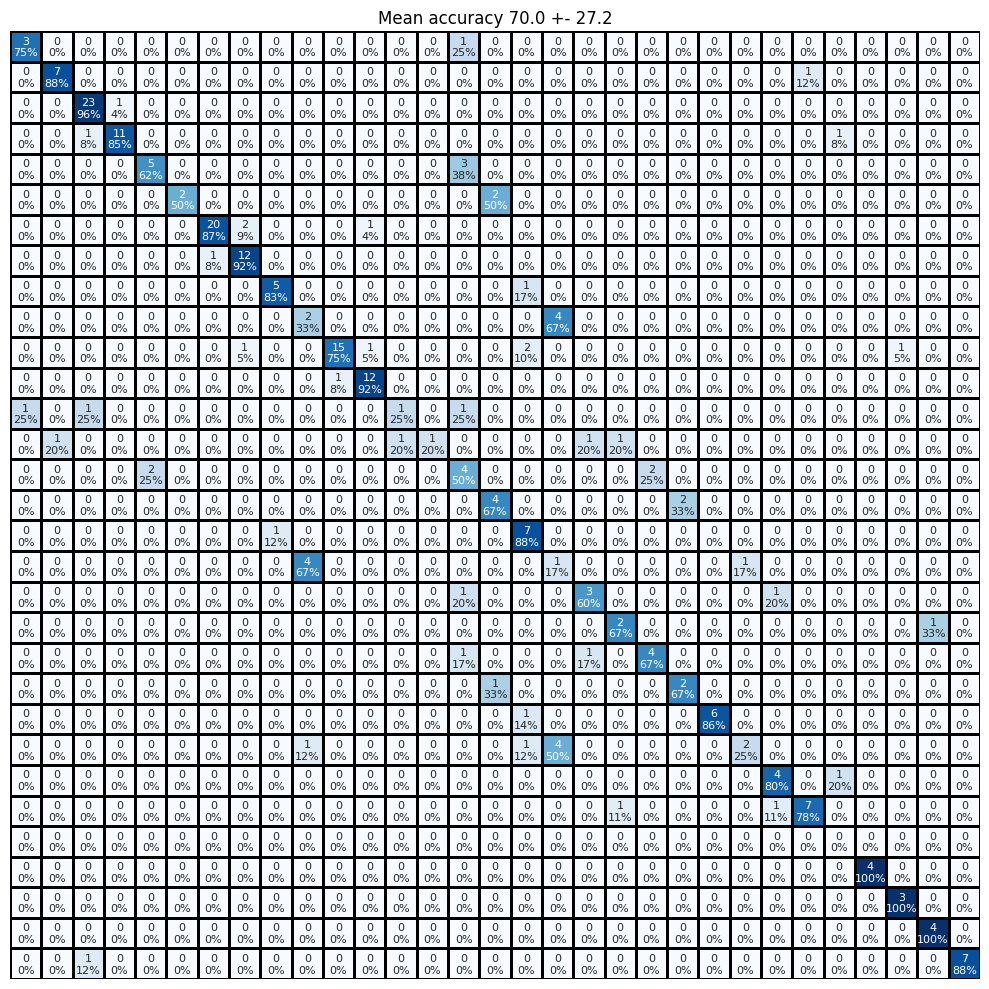

In [29]:
create_and_plot_cm(y_test_pred, y_test)

In [30]:
class Confidence:

    def __init__(self, multiple_preds):
        self.multiple_preds = multiple_preds
        self._uncertainty_metrics = dict()
        self._uncertainty_metrics['entropy'] = self._entropy
        self._uncertainty_metrics['variance'] = self._variance
        self._uncertainty_metrics['max_softmax_response'] = self._max_softmax_response

    def compute_uncertainty_metrics(self):
        return {metric: self._compute_uncertainty(
            metric,
            self.multiple_preds) for metric in self._uncertainty_metrics.keys()}

    def _normalize(self, values):
            return (values - values.min())/(values.max()-values.min())

    def _compute_uncertainty(self, metric, multiple_preds):
        try:
            print("Done {}".format(metric))
            return self._normalize(
                self._uncertainty_metrics[metric](multiple_preds))
        except KeyError:
            print("{} not implemented.".format(metric))

    def _avreage_prediction(self, multiple_preds):
        if len(multiple_preds.shape) > 2:
            return np.mean(np.array(multiple_preds), axis=0)
        else:
            return multiple_preds

    def _entropy(self, multiple_preds):
        avg_preds = self._avreage_prediction(multiple_preds)
        eps = 1e-5
        entropy = -1 * np.sum(avg_preds * np.log(avg_preds + eps), axis=1)
        return entropy

    def _variance(self, multiple_preds):
        avg_preds = self._avreage_prediction(multiple_preds)
        return  np.var(avg_preds, axis=1)

    def _max_softmax_response(self, multiple_preds):
        avg_preds = self._avreage_prediction(multiple_preds)
        return np.max(avg_preds, axis=1)

def anomaly_detection_metric(anomaly_start_timestamps, confidence, df_dataset, thresholds, less_than=True):
    "Actual is y axis"
    if not less_than:
        confidence = 1 - confidence

    sens = list()
    spec = list()
    fpr = list()
    f1 = list()
    prec = list()
    cm_list = list()
    anomaly_indexes_dict = dict()
    acc_with_err = list()
    for threshold in thresholds:
        df_not_confident = df_dataset[confidence <= threshold]
        tp = 0
        anomaly_indexes = list()
        for anomaly in anomaly_start_timestamps:
            for index, row in df_not_confident.iterrows():
                if anomaly >= row['start'] and anomaly <= row['end']:
                    anomaly_indexes.append(index)
                    tp += 1

        cm_anomaly = np.zeros((2, 2))
        n_samples = len(df_dataset)
        n_not_collisions = n_samples - len(anomaly_start_timestamps)
        n_detected = len(df_not_confident)

        fp = n_detected - tp
        fn = len(anomaly_start_timestamps) - tp
        tn = n_not_collisions - fp

        cm_anomaly[0][0] = tn
        cm_anomaly[1][1] = tp
        cm_anomaly[0][1] = fp
        cm_anomaly[1][0] = fn
        cm_list.append(cm_anomaly)
        sens.append(tp / (tp + fn))
        recall = tp / (tp + fn)
        prec.append(tp / (tp + fp))
        spec.append(tn / (fp + tn))
        fpr.append(1 - tn / (fp + tn))
        try:
            f1.append(2 * tp / (2 * tp + fp + fn) )
        except ZeroDivisionError:
            f1.append(0)
        cm_anomaly_norm = cm_anomaly.astype('float') / cm_anomaly.sum(axis=1)[:, np.newaxis]
        acc_with_err.append((np.mean(np.diag(cm_anomaly_norm)),
                            np.std(np.diag(cm_anomaly_norm))))


        anomaly_indexes_dict[threshold] = anomaly_indexes
    return sens, spec, fpr, f1, cm_list, anomaly_indexes_dict, acc_with_err, prec

In [31]:
n_mc = 10
preds_list = [clf.model.predict(X_test.values, verbose=0) for _ in range(n_mc)]
preds_array = np.array(preds_list)
print(preds_array.shape)
preds_bayes_mean = np.mean(preds_array, axis=0)

(10, 244, 31)


In [32]:
uncertainties_bayes = dict()
uncertainties_bayes["correct"] = Confidence(preds_array.mean(axis=0)[(preds_bayes_mean.argmax(axis=1) == y_test), :]).compute_uncertainty_metrics()
uncertainties_bayes["wrong"] = Confidence(preds_array.mean(axis=0)[(preds_bayes_mean.argmax(axis=1) != y_test), :]).compute_uncertainty_metrics()
uncertainties_bayes["all"] = Confidence(preds_array.mean(axis=0)).compute_uncertainty_metrics()

Done entropy
Done variance
Done max_softmax_response
Done entropy
Done variance
Done max_softmax_response
Done entropy
Done variance
Done max_softmax_response


In [33]:
# Set style for matplotlib
plt.style.use("Solarize_Light2")

In [34]:
def plot_uncertainty(uncertainties, title):
    fig, axes = plt.subplots(len(uncertainties['correct'].keys()), 3, figsize=(15, 9))
    for ax, measure in zip(axes, uncertainties['correct'].keys()):
        ax[0].set_title(f"Wrong - {measure}")
        ax[0].hist(uncertainties['wrong'][measure], color="red", log=False, bins=25, edgecolor='black', linewidth=1.2, alpha=0.5);
        ax[1].set_title(f"Correct - {measure}")
        ax[1].hist(uncertainties['correct'][measure], color="green", log=False, bins=25, edgecolor='black', linewidth=1.2, alpha=0.5);
        ax[2].set_title(f"All - {measure}")
        ax[2].hist(uncertainties['all'][measure], color="blue", log=False, bins=25, edgecolor='black', linewidth=1.2, alpha=0.5);
    fig.suptitle(title, fontsize=20)
    plt.tight_layout()
    plt.show()

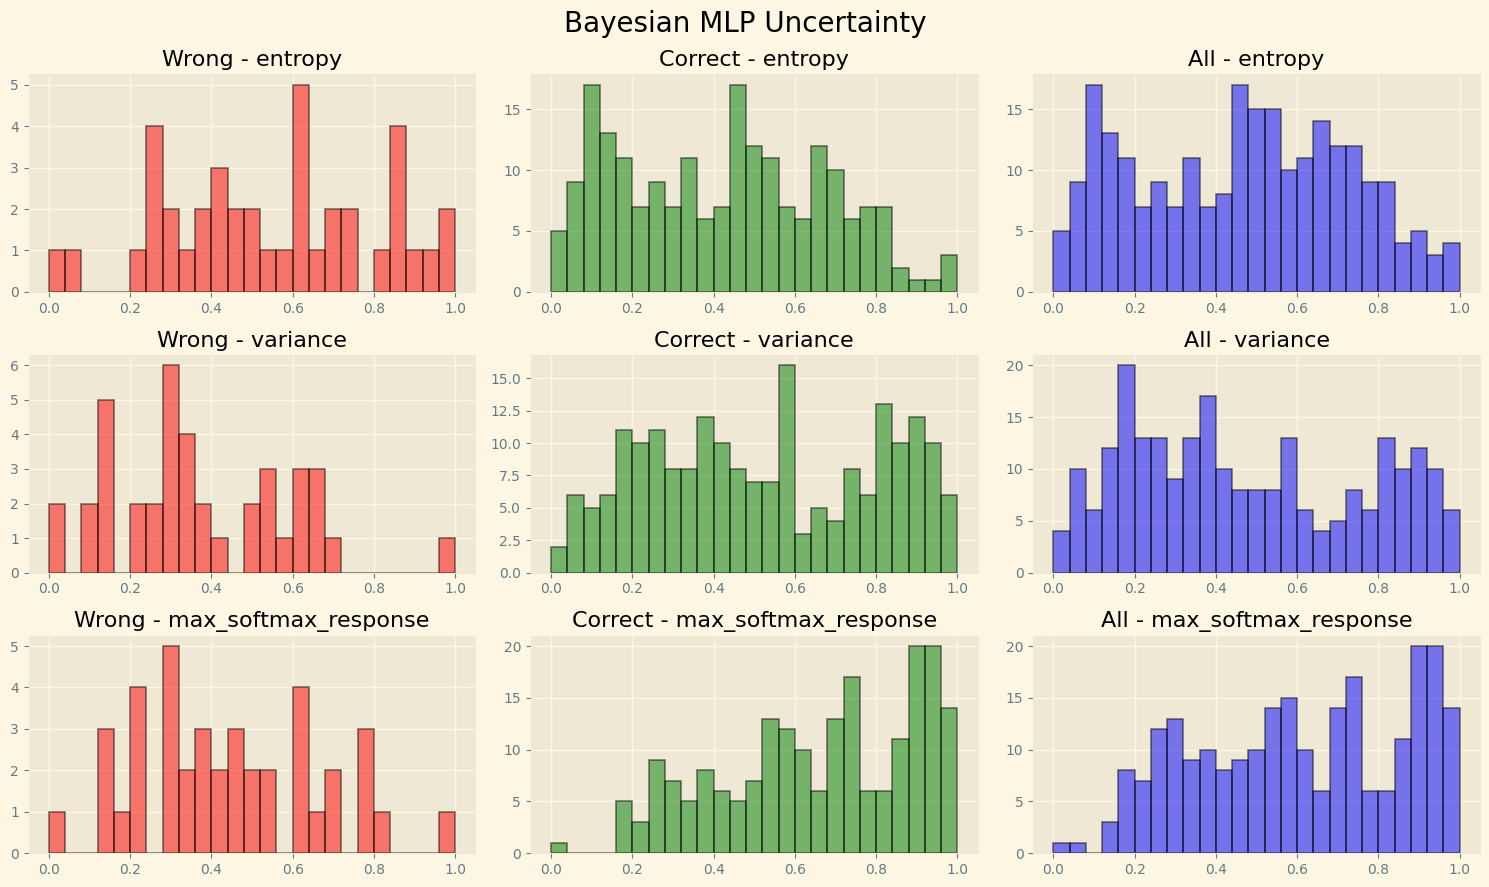

In [35]:
plot_uncertainty(uncertainties_bayes, "Bayesian MLP Uncertainty")

In [36]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming y_test_pred are your model predictions and y_test are the actual labels
# Note: if y_test_pred is in a one-hot encoded format, convert it to class labels first
y_pred_classes = y_test_pred.argmax(axis=1)

accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes, average='macro')
recall = recall_score(y_test, y_pred_classes, average='macro')
f1 = f1_score(y_test, y_pred_classes, average='macro')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.75
Precision: 0.7084241475370509
Recall: 0.6775847379984827
F1 Score: 0.672601823368327


In [37]:
ROOTDIR_DATASET_ANOMALY = "./dataset/collisions/"

In [38]:
print(os.path.join(ROOTDIR_DATASET_ANOMALY, "20220811_collisions_timestamp.xlsx"))

./dataset/collisions/20220811_collisions_timestamp.xlsx


In [39]:
xls = pd.ExcelFile(os.path.join(ROOTDIR_DATASET_ANOMALY, "20220811_collisions_timestamp.xlsx"))
collision_rec1 = pd.read_excel(xls, 'rec1')
collision_rec5 = pd.read_excel(xls, 'rec5')

In [40]:
collisions = pd.concat([collision_rec1, collision_rec5])
collisions_init = collisions[collisions['Inizio/fine'] == "i"].Timestamp - pd.to_timedelta([2] * len(collisions[collisions['Inizio/fine'] == "i"].Timestamp), 'h')

In [41]:
collisions

,Inizio/fine,Timestamp
0,i,2022-08-11 16:02:17.450
1,f,2022-08-11 16:02:21.460
2,i,2022-08-11 16:02:28.320
3,f,2022-08-11 16:02:31.420
4,i,2022-08-11 16:02:45.770
...,...,...
107,f,2022-08-11 19:03:02.080
108,i,2022-08-11 19:03:44.090
109,f,2022-08-11 19:03:48.150
110,i,2022-08-11 19:04:10.600


In [42]:
filepath_csv = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec{r}_collision_20220811_rbtc_0.1s.csv") for r in [1, 5]]
filepath_meta = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec{r}_collision_20220811_rbtc_0.1s.metadata") for r in [1, 5]]
df_action, df, df_meta, action2int = ds.get_df_action(filepath_csv, filepath_meta)

Loading data.
Found 31 different actions.
Loading data done.



In [43]:
start_time = time.time()
df_features_collision = ds.get_features_ts("statistical", df_action, df_meta, 10, action2int)
print("--- %s seconds ---" % (time.time() - start_time))

Computing features.


Skipped feature extraction for moveOverPallet(1,3)=[true,0] 2022-08-11 16:55:15.149000 : 2022-08-11 16:55:15.146000.
Skipped feature extraction for moveOverPallet(3,1)=[true,0] 2022-08-11 16:55:15.146000 : 2022-08-11 16:55:15.150000.
Computing features done.
--- 32.68411350250244 seconds ---


In [44]:
df_features_collision.isnull().values.any()

True

In [45]:
df_features_collision_nonan = df_features_collision.fillna(0)

In [46]:
X_collision = df_features_collision_nonan.drop(["label", "start", "end"], axis=1)
y_collision = df_features_collision_nonan["label"]

In [47]:
X_collision = pd.DataFrame(selector_variance.transform(scaler.transform(X_collision)),
                           columns=X_collision.columns.values[selector_variance.get_support()])
X_collision.drop(corr_features, inplace=True, axis=1)
X_collision = X_collision[selected_features].copy()

In [48]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming y_test_pred are your model predictions and y_test are the actual labels
# Note: if y_test_pred is in a one-hot encoded format, convert it to class labels first
y_test_pred_collision = clf.predict(X_collision.values)
y_pred_classes = y_test_pred_collision.argmax(axis=1)

accuracy = accuracy_score(y_collision, y_pred_classes)
precision = precision_score(y_collision, y_pred_classes, average='macro')
recall = recall_score(y_collision, y_pred_classes, average='macro')
f1 = f1_score(y_collision, y_pred_classes, average='macro')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

10/10 [==============================] - 0s 992us/step
Accuracy: 0.5359477124183006
Precision: 0.5967525885457575
Recall: 0.5040591397849462
F1 Score: 0.5184780321235382


In [49]:

preds_list_collision = [clf.model.predict(X_collision.values, verbose=0) for _ in range(n_mc)]
preds_array_collisions = np.array(preds_list_collision)
print(preds_array_collisions.shape)
preds_bayes_mean_collision = np.mean(preds_array_collisions, axis=0)


(10, 306, 31)


In [50]:

uncertainties_bayes = dict()
uncertainties_bayes["correct"] = Confidence(preds_array_collisions.mean(axis=0)[(preds_bayes_mean_collision.argmax(axis=1) == y_collision), :]).compute_uncertainty_metrics()
uncertainties_bayes["wrong"] = Confidence(preds_array_collisions.mean(axis=0)[(preds_bayes_mean_collision.argmax(axis=1) != y_collision), :]).compute_uncertainty_metrics()
uncertainties_bayes["all"] = Confidence(preds_array_collisions.mean(axis=0)).compute_uncertainty_metrics()


Done entropy
Done variance
Done max_softmax_response
Done entropy
Done variance
Done max_softmax_response
Done entropy
Done variance
Done max_softmax_response


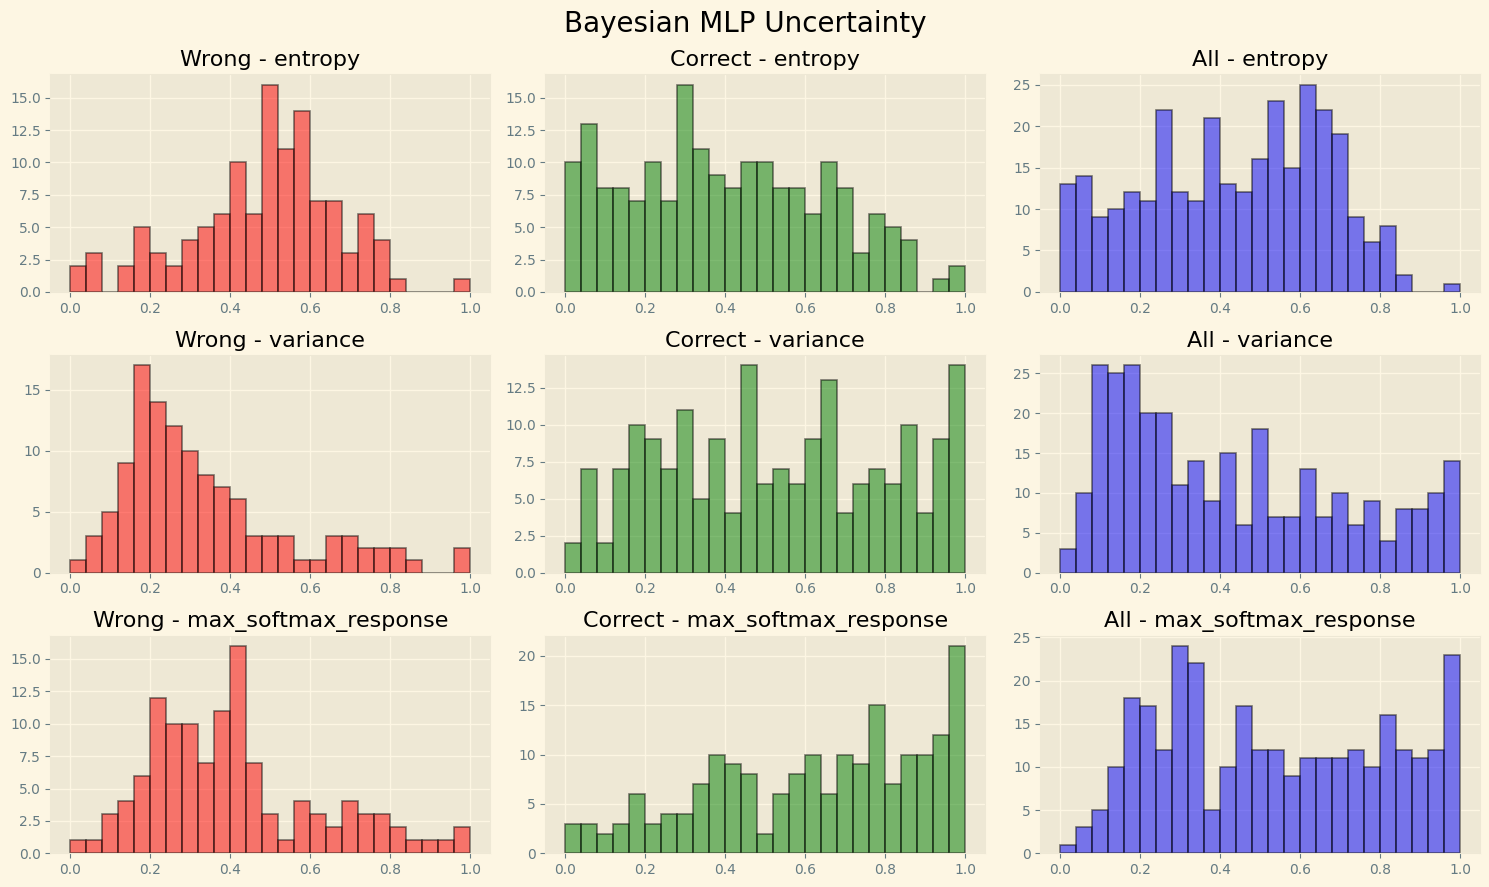

In [51]:
plot_uncertainty(uncertainties_bayes, "Bayesian MLP Uncertainty")

Confusion Matrix:

Classification Report:
              precision    recall  f1-score   support

           0       0.36      1.00      0.53        12
           1       0.58      0.70      0.64        10
           2       0.57      0.44      0.50         9
           3       0.95      0.67      0.78        27
           4       0.93      0.72      0.81        18
           5       0.80      0.44      0.57         9
           6       0.67      0.44      0.53         9
           7       0.90      0.67      0.77        27
           8       1.00      0.67      0.80        18
           9       0.35      0.67      0.46         9
          10       0.67      0.44      0.53         9
          11       1.00      0.72      0.84        25
          12       0.71      0.62      0.67        16
          13       0.09      0.50      0.16         6
          14       1.00      0.17      0.29         6
          15       0.75      0.50      0.60         6
          16       0.33      0.17      

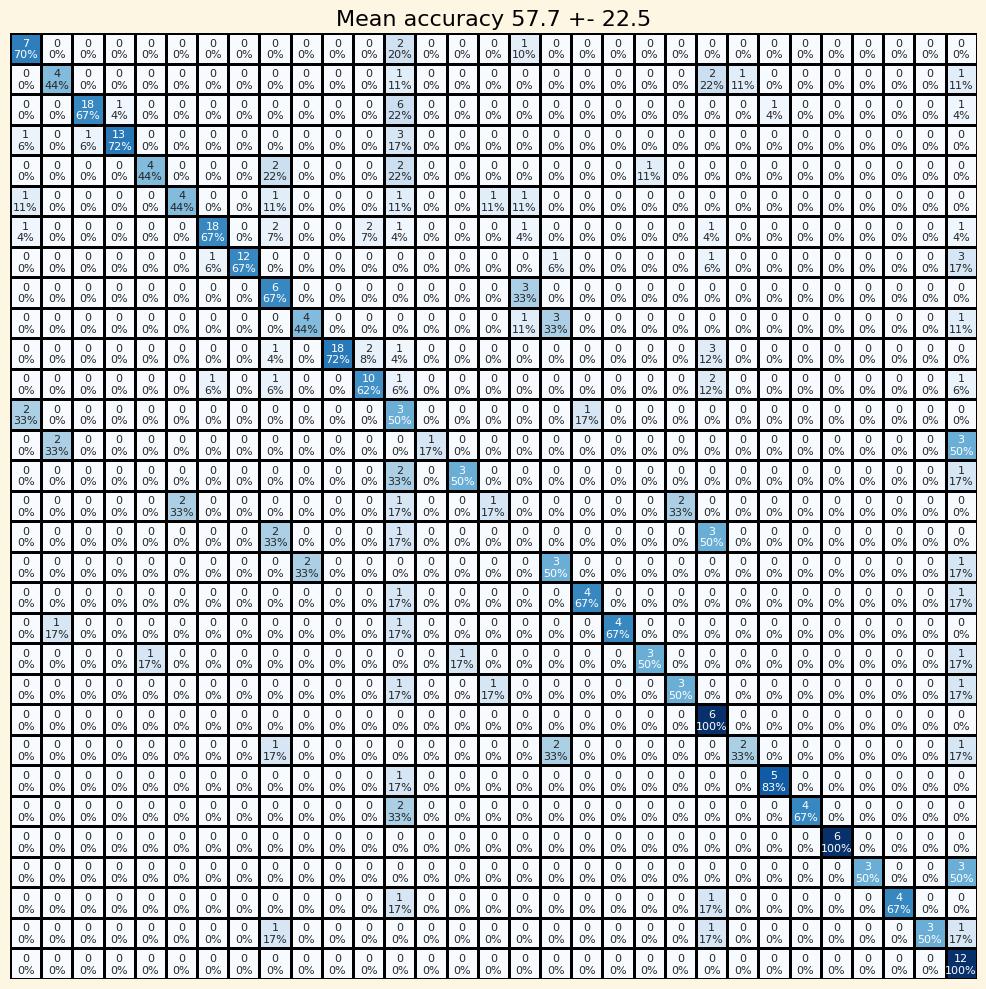

In [52]:
from sklearn.metrics import classification_report, confusion_matrix

# Assuming you have y_collision as the true labels for the collision dataset
y_pred_collision_classes = preds_bayes_mean_collision.argmax(axis=1)

print("Confusion Matrix:")
create_and_plot_cm(preds_bayes_mean_collision, y_collision)

print("\nClassification Report:")
print(classification_report(y_collision, y_pred_collision_classes))

In [53]:
roc_dict = dict()
for confidence_metric in uncertainties_bayes['correct'].keys():
    confidence = uncertainties_bayes['all'][confidence_metric]
    if confidence_metric == "entropy":
        confidence = 1- confidence
    sens = list()
    fpr = list()
    for threshold in np.arange(0, 1, 0.1):
        df_not_confident = df_features_collision_nonan[confidence <= threshold]
        anomaly_indexes = list()
        tp = 0
        for anomaly in collisions_init:
            for index, row in df_not_confident.iterrows():
                if anomaly >= row['start'] and anomaly <= row['end']:
                    anomaly_indexes.append(index)
                    tp += 1

        cm_anomaly = np.zeros((2, 2))
        n_samples = len(df_features_collision_nonan)
        n_not_collisions = n_samples - len(collisions_init)
        n_detected = len(df_not_confident)

        fp = n_detected - tp
        fn = len(collisions_init) - tp
        tn = n_not_collisions - fp
        cm_anomaly[0][0] = tn
        cm_anomaly[1][1] = tp
        cm_anomaly[0][1] = fp
        cm_anomaly[1][0] = fn
        sens.append(tp / (tp + fn))
        fpr.append(1 - tn / (fp + tn))
    roc_dict[confidence_metric] = (fpr, sens)

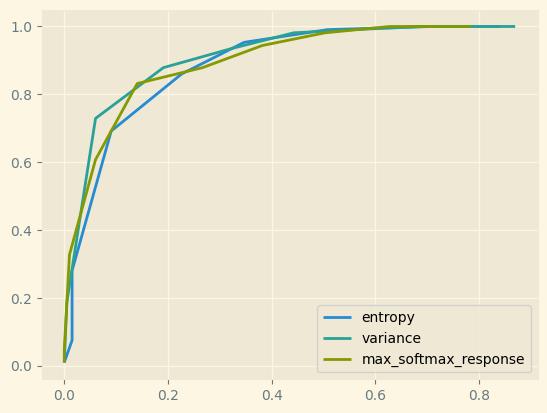

In [54]:

fig, ax = plt.subplots(1, 1)
for confidence_metric in uncertainties_bayes['correct'].keys():
    ax.plot(roc_dict[confidence_metric][0], roc_dict[confidence_metric][1], label=confidence_metric)
ax.legend();

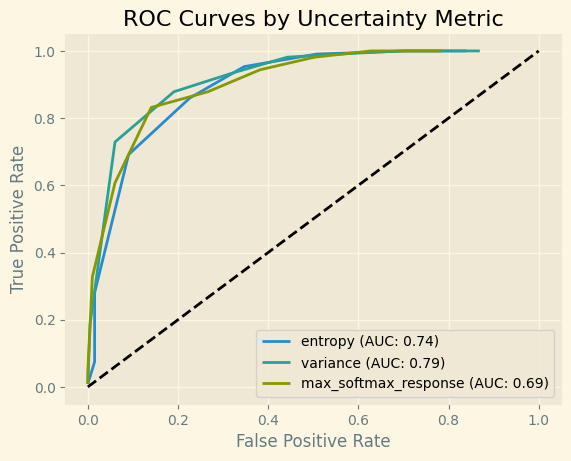

In [55]:
import matplotlib.pyplot as plt
from sklearn.metrics import auc

fig, ax = plt.subplots()
for confidence_metric, (fpr, sens) in roc_dict.items():
    ax.plot(fpr, sens, label=f'{confidence_metric} (AUC: {auc(fpr, sens):.2f})')
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curves by Uncertainty Metric')
ax.legend(loc='lower right')
plt.show()


In [80]:
y_pred_collision = clf.predict(X_collision.values)
y_pred_collision_classes = y_pred_collision.argmax(axis=1)
missclassified = y_collision != y_pred_collision_classes
print(f"Missclassified samples: {missclassified}")
print(f"Number of Missclassified samples: {missclassified.sum()}")

total_collision = len(collisions_init)

print(f"Total number of collisions: {total_collision}")


10/10 [==============================] - 0s 1ms/step
Missclassified samples: 0    False
1    False
2    False
3    False
4    False
     ...  
0    False
0    False
0     True
0     True
0     True
Name: label, Length: 306, dtype: bool
Number of Missclassified samples: 132
Total number of collisions: 107
